# Detection of Rossby wave breaking by using two different indices

Author: Severin Kaderli - University of Bern <br> 
Mail: severin.kaderli@students.unibe.ch

This algorithm detects and classifies Rossby Wave Breaking (RWB). <br>
An xarray data set including the dimensions lat, lot at a specific time step is used as an input. <br>

The algorithms follows these steps:
* Step 1: Extract a contour line of a specific value (see Contour Extraction Algorithm script also avaiable on GitHub) 
* Step 2: Apply one of two indices:
    - Streamer index by Wernli and Sprenger (2007). <br> The events are distinguished by stratospheric/tropospheric streamers or by cyclonic/anticyclonic streamers. <br> For the distinction between cyclonic/anticyclonic events, the momentum flux must be provided. 
    - Overturning index by Barnes and Hartmann (2012). <br> The events are distinguished by cyclonic/anticyclonic by using two different methods. 
* Step 3: Save results
* Step 4: Visualize results. 

## Preparations
### Import packages

In [1]:
# for data
import xarray as xr
import metpy.calc as mpcalc

# for algorithm
import numpy as np
import itertools as itertools
from skimage import measure
from scipy import spatial
import pandas as pd
from shapely.geometry import LineString
from matplotlib.path import Path
from scipy import ndimage
from math import sqrt
from skimage.draw import line
from tqdm import tqdm
import wrf as wrf

# for plotting
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

### Load data

In [2]:
# specify names of the coordinates
lat_name = "lat"
lon_name = "lon"
time_name = "time"

# load data
ds_var = xr.open_dataset("/scratch3/severin/data/era5/pv/pv330_1979-2019.nc")
ds_flux =xr.open_dataset("/scratch3/severin/data/era5/wind/flux_zm_1979-2019.nc")

# combine in one dataset
ds = ds_var
ds["flux"] = ds_flux.flux

# Select time steps, variable, contour level, and index
ds = ds.isel(time=slice(0,365))
var_name = "pv"
level = 2
index = "streamer" #"streamer" or "ot"

## Subroutines
### Contour Extraction Algorithm

In [3]:
def extract_contour(dataset, level, y_overlap = 1, x_extent = 0.3, single = True, scale = True):
    """
    Extracts contour by using the "find_contours" function of "measure" by "skimage".
    The coordinates of the contour points can be mapped on a grid with the same resolution as the input field.
    Unclosed contours at longitude border according to their start and end point can be grouped. 
    Contours with a too small extent in x direction can be dropped.
    
    Input:
    -----
    dataset: xarray
        xarray without time coordinate
        
    level: float
        contour level
        
    y_overlap: float, optional
        Overlap in y direction in degrees in between unclosed contours at longitude border are grouped
    
    x_extent: float, optional
        Set minimal extents of a contour in the x direction. A coverage of all longitudes means x_extent = 1.
        
    single: boolean, optional
        Select if only one contour (largest with contour with smallest mean latitude) should be kept
    
    scale: boolean, optional
        Select if the contour should be rescaled on a grid with the same resolution as the input dataset
    
    Returns:
    -------
    dataframe: float
        Dataframe with columns lon and lat
        
    """
    
    #**************************
    #define subroutines
    
    def get_contour(dataset, level):
        """
        Extracts contour by using the "find_contours" function of "measure" by "skimage".
        Output is modified in order to fit the original coordinates.
        
        """
        return [np.c_[contour[:,1]+min(ds[lon_name].values),contour[:,0]] for contour in measure.find_contours(dataset[var_name].values,level)]
    
    def rescale_contours(contours):
        """
        Rescale the coordinates of the contour points on a grid with the same resolution as the input field.
        
        """
        x, y = np.meshgrid(ds[lon_name],ds[lat_name]) 
        x, y = x.flatten(), y.flatten()
        grid_points = np.vstack((x,y)).T 
        tree = spatial.KDTree(grid_points)

        contours_scaled = []
        for contour in contours:
            temp = []
            for point in contour:
                temp.append(grid_points[tree.query([point])[1][0]])
            unique = list(dict.fromkeys(map(tuple,temp)))
            contours_scaled.append(np.asarray(unique))

        return contours_scaled
    
    def group_contours(contours, y_overlap):
        """
        Group unclosed contours at longitude border according to their start and end point.
        
        """
        contours_index = list(range(0,len(contours)))
        borders = []
        for contour,index in zip(contours,contours_index):
            stp = contour[0].tolist()
            ndp = contour[-1].tolist()
            borders.append([index]+stp+ndp)

        start = [[border[1],border[2]] for border in borders]
        end = [[border[3],border[4]] for border in borders]
        both = start+end

        lon_border = [int(ds[lon_name].values.min()), int(ds[lon_name].values.max())]

        for point in both:
            ind = [i for i, x in enumerate(both) if (x[0]==point[0] or all(i in [x[0],point[0]] for i in lon_border)) and point[1]-y_overlap <= x[1] <= point[1]+y_overlap]
            ind = np.mod(ind,len(contours))
            add = [borders[i][0] for i in ind]
            for i in ind:
                borders[i][0] = borders[min(add)][0]    

        all_values = [border[0] for border in borders]
        unique_values = set(all_values)

        contours_grouped = []
        for value in unique_values:
            this_group = []
            for border,contour in zip(borders,contours):
                if border[0] == value:
                    this_group.append(contour)
            contours_grouped.append(this_group)

        contours_grouped_sorted = []
        for group in contours_grouped:
            if len(group) > 1:
                bigest = sorted(group, key=len, reverse=True)[0]
                rest = sorted(group, key=len, reverse=True)[1:]

                temp = [bigest]
                while len(rest) > 0:
                    test = temp[-1][-1,1]
                    for item,ind in zip(rest, range(0,len(rest))):
                        if test-y_overlap <= item[0,1] <= test+y_overlap:
                            temp.append(item)
                            break
                    del rest[ind]
                contours_grouped_sorted.append(np.asarray(list(itertools.chain.from_iterable(temp))))
            else:
                contours_grouped_sorted.append(np.asarray(list(itertools.chain.from_iterable(group))))

        return contours_grouped_sorted
    
    def filter_contours(contours, x_extent):
        """
        Contours with a too small extent in x direction are dropped.

        """
        lons = ds[lon_name].values
        contour_extent = [len(np.unique(np.round(contour[:,0]))) for contour in contours]
        test_extent = [extent/len(lons) >= x_extent for extent in contour_extent]

        return list(itertools.compress(contours, test_extent))
    
    def single_contours(contours):
        """
        Keeps largest contour.
        If there are two contours fully encircling the pole, the one with the smaller mean latitude is kept. 

        """
        lons = ds[lon_name].values
        contour_extent = [len(np.unique(np.round(contour[:,0]))) for contour in contours]

        if sum([i==1 for i in contour_extent])>1: 
            mean_lat = [np.mean(contour[:,1]) for contour in contours]
            contours_single = contours[mean_lat.index(min(mean_lat))]
        else: 
            contours_single = contours[contour_extent.index(max(contour_extent))]

        return contours_single

    def df_contours(contours):
        """
        Store final contours in a pandas dataframe

        """
        if type(contours)==list:
            temp = np.asarray(list(itertools.chain.from_iterable(contours)))
        else:
            temp = contours
        return pd.DataFrame({'lon': temp[:,0].tolist(), 'lat': temp[:,1].tolist()})
    
    #**************************

    contours = get_contour(dataset, level)
    
    if scale == True:
        contours_scaled = rescale_contours(contours)
    else:
        contours_scaled = contours
        
    contours_grouped = group_contours(contours_scaled, y_overlap)
    
    contours_filtered = filter_contours(contours_grouped, x_extent)
    
    if contours_filtered !=[]:
        if single == True:
            contours_return = single_contours(contours_filtered)
        else:
            contours_return = contours_filtered
            
        return df_contours(contours_return)
            
    else:
        return []

### Utility and Index functions

In [4]:
# Utility functions

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the Earth
    
    Input:
    -----
    lon1, lat1, lon2, lat2: float
        Longitude and latitude values of both points
        
    Returns:
    -------
    km: float
        Great circle distance in km

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def map_on_grid(obj,value=1):
    """
    Map a objetct with coordinate points on a grid with the same resolution as the input field
    
    Input: 
    -----
    obj: dataframe
        Object in form of a dataframe with the colmuns lon and lat
        
    value: float, optional
        value which is assigned on the grid to the coordinates present in the dataframe
        
    Returns:
    ------
    data_array: array
        Array with 0 and "value" marking the location of the identified events 
    
    """
    data_array = np.zeros([len(ds[lat_name]),len(ds[lon_name])])
    if len(obj) > 0:
        for index,row in obj.iterrows():
            data_array[int(row["lat"]),int(row["lon"])+int(max(ds[lon_name].values))] = value
        return data_array
    else:
        return data_array

# Streamer index    
    
def get_basepoints(df_contour,geo_dis,cont_dis):
    """
    Extract all basepoint pairs of a given contour. 
    Basepoints are coordinate pairs that are close regarding their geographical distance (geo_dis), 
    but far apart regarding their connection on the contour (cont_dis).
    
    Input:
    -----
    df_contour: dataframe
        Contour in form of a dataframe with the columns lon and lat
        
    geo_dis: float
        Maximal geographical distance between two basepoints in km
        
    cont_dis: float
        Minimal distance between two basepoints on the contour in km
        
    Returns:
    -------
    list: pair of int
        List with pairs of indicies (point position on contour) of all basepoints. 
        The list does not contain duplicates ((1,5) and (5,1))
    
    """
    
    #Calculate geographical distance between all point pairs
    comb = np.asarray(list(itertools.combinations(df_contour.index, r=2)))

    df1 = df_contour.iloc[comb[:,0]].reset_index().rename(columns={"lon":"lon1", "lat":"lat1", "index":"ind1"})
    df2 = df_contour.iloc[comb[:,1]].reset_index().rename(columns={"lon":"lon2", "lat":"lat2", "index":"ind2"})
    df = pd.concat([df1,df2], axis=1)
    
    km = haversine_np(df['lon1'],df['lat1'],df['lon2'],df['lat2'])
    geo_close = df[km<geo_dis][["ind1","ind2"]].values.tolist()
    
    #Calculate distance along the contour
    dis = pd.concat([df_contour,pd.DataFrame(np.roll(df_contour,-1,axis=0), columns=["lon_s","lat_s"])], axis=1)
    ongoing_distance = haversine_np(dis['lon'],dis['lat'],dis['lon_s'],dis['lat_s'])

    def contour_distance(pair):
        """
        Calculate distance on contour in km using the great circle distance.
        """
        i = min(pair)
        j = max(pair)

        dis1 = ongoing_distance.values[i:j+1].sum()
        dis2 = ongoing_distance.values[j:].sum() + ongoing_distance.values[:i+1].sum()

        return min([dis1,dis2])
    
    #Keep point pairs, which fulfill the requirements
    basepoints = [[min(pair),max(pair)] for pair in geo_close if contour_distance(pair) > cont_dis]

    return list(map(list,set(map(tuple,basepoints))))

def get_streamers(df_contour, bp_list):
    """
    Indentify unique streamers based on the detected basepoints. 
    
    Input:
    -----
    df_contour: dataframe
        Contour in form of a dataframe with the columns lon and lat
    
    bp_list: list
        List with pairs of indicies (point position on contour) of all basepoints
    
    Returns:
    -------
    list: dataframe
        List of dataframes, each representing a streamer.
        
    
    """
    contour_points = [[df_contour["lon"][i],df_contour["lat"][i]] for i in range(0,len(df_contour))]
    cont_line = LineString(contour_points)

    def test_intersection(pair):
        """
        Check that the connection between a pair of base points does not intersect with the contour
        """
        i = pair[0]
        j = pair[1]

        # check 1

        point1 = tuple(map(int,(df_contour["lat"][i],df_contour["lon"][i]+180)))
        point2 = tuple(map(int,(df_contour["lat"][j],df_contour["lon"][j]+180)))

        grid = np.zeros([len(ds[lat_name]),len(ds[lon_name])])
        rr,cc = line(point1[0], point1[1], point2[0], point2[1])
        grid[rr, cc] = 1
        line_points = list(zip(*np.where(grid == 1)))

        contour_tuples = [(x[1], x[0]+180) for x in df_contour.to_numpy()]

        test = [i for i in line_points if i in contour_tuples and i not in [point1,point2]]

        # check 2

        lines = LineString([(df_contour["lon"][i],df_contour["lat"][i]),(df_contour["lon"][j],df_contour["lat"][j])])

        if test == [] and lines.crosses(cont_line) == False:
            return False
        else:
            return True

    bp_crossing = [pair for pair in bp_list if test_intersection(pair)==False]
    
    def test_wrapping(pair):
        """
        Drop all pairs that are fully wrapped by another pair
        """
        i = pair[0]
        j = pair[1]

        a = bp_crossing[i][0] < bp_crossing[j][0]
        b = bp_crossing[i][1] > bp_crossing[j][1]

        c = bp_crossing[i][0] == bp_crossing[j][0]
        d = bp_crossing[i][1] == bp_crossing[j][1]

        if (a == True and d == True) or (b == True and c == True):
            return j
        elif (a == False and d == True) or (b == False and c == True):
            return i
        else:
            return -1

    wrapped = [test_wrapping(pair) for pair in itertools.combinations(range(0,len(bp_crossing)), r=2)]
    bp_wrapping = [item for i,item in enumerate(bp_crossing) if i not in wrapped]

    def test_overlap(i, j):
        """
        Identify pairs that share over 50% of their connecting contour points and group them together
        """
        i_range = list(range(bp_wrapping[i][0],bp_wrapping[i][1]+1))
        j_range = list(range(bp_wrapping[j][0],bp_wrapping[j][1]+1))

        overlap = list(set(i_range) & set(j_range))
        i_p, j_p = 0,0
        if len(i_range) != 0: 
            i_p = len(overlap)/len(i_range)
        if len(j_range) != 0: 
            j_p = len(overlap)/len(j_range)

        if i_p > 0.8 and j_p > 0.8:
            return True
        else:
            return False

    combine = [[i,j] for i,j in itertools.combinations_with_replacement(range(0,len(bp_wrapping)), r=2) if test_overlap(i,j)]

    combine_set = []
    iterator = combine.copy()
    while len(iterator)>0:
        first, *rest = iterator
        first = set(first)
        lf = -1
        while len(first)>lf:
            lf = len(first)
            rest2 = []
            for r in rest:
                if len(first.intersection(set(r)))>0:
                    first |= set(r)
                else:
                    rest2.append(r)     
            rest = rest2
        combine_set.append(first)
        iterator = rest

    def get_unique(group):
        """
        For grouped pairs, keep the one closest to the start and end point of the group
        """
        temp = [bp_wrapping[item] for item in group]
        mn = np.asarray(temp)[:,0].min()
        mx = np.asarray(temp)[:,1].max()
        weight = [sqrt((mn-point[0])**2+(mx-point[1])**2) for point in temp]

        return temp[np.argmin(np.asarray(weight))]

    bp_unique = [get_unique(group) for group in combine_set]

    #return all contour points in a dataframe lying on a connection between two basepoints
    return [df_contour[item[0]:item[1]+1] for item in bp_unique]

def get_gridpoints_streamer(streamers_list):
    """
    Provide the gridpoints representing the streamer.
    The streamer is closed trough a direct connection between start and end point. 
    
    Input:
    -----
    streamers_list: list of dataframes
        List of dataframes, each representing a streamer in form of contour points 
        
    Returns:
    -------
    list: dataframes
        List of dataframes, each representing all grid points enclosed by a streamer
        
    """
    x, y = np.meshgrid(ds[lon_name],ds[lat_name]) 
    x, y = x.flatten(), y.flatten()
    grid_points = np.vstack((x,y)).T  
    
    def get_grid(streamer):
        """
        Get all grid points enclosed by the streamer path. 
        """
        p = Path(np.c_[streamer["lon"], streamer["lat"]])
        grid = p.contains_points(grid_points)
        
        return pd.DataFrame({'lon': grid_points[grid][:,0].tolist(), 'lat': grid_points[grid][:,1].tolist()})
    
    return [get_grid(streamer) for streamer in streamers_list if len(get_grid(streamer))>0]

# Overturning index

def get_overturning(df_contour,ot_lons):
    """
    Identification of unique overturning events. 
    
    Input:
    -----
    df_contour: dataframe
        Contour in form of a dataframe with the columns lon and lat
    
    ot_lons: list
        List longitudes that are crossed at least three times by the contour
    
    Returns:
    -------
    list: dataframe
        List of dataframes, each representing an overturning event.

    """
    
    ot_f0 = [list(df_contour["lon"][df_contour["lon"] == lon].index) for lon in ot_lons]

    #Calculate distance along the contour
    dis = pd.concat([df_contour,pd.DataFrame(np.roll(df_contour,-1,axis=0), columns=["lon_s","lat_s"])], axis=1)
    ongoing_distance = haversine_np(dis['lon'],dis['lat'],dis['lon_s'],dis['lat_s'])

    def contour_distance(pair):
        """
        Calculate distance on contour in km using the great circle distance between the members of both pairs.
        """
        i = min(pair)
        j = max(pair)

        dis1 = ongoing_distance.values[i:j+1].sum()
        dis2 = ongoing_distance.values[j:].sum() + ongoing_distance.values[:i+1].sum()

        return min([dis1,dis2])

    comb = list(itertools.combinations_with_replacement(list(range(0,len(ot_f0))), r=2))

    def compare_groups(pair):
        """
        Compare contour distance between groups.
        """
        i = ot_f0[pair[0]]
        j = ot_f0[pair[1]]

        combs = list(itertools.product(i,j))

        for c in combs:
            if contour_distance(c) <= cont_apart:
                return True

        return False


    #Group events that are close enough
    comb1 = [pair for pair in comb if compare_groups(pair)]

    comb2 = []
    iterator = comb1.copy()
    while len(iterator)>0:
        first, *rest = iterator
        first = set(first)
        lf = -1
        while len(first)>lf:
            lf = len(first)
            rest2 = []
            for r in rest:
                if len(first.intersection(set(r)))>0:
                    first |= set(r)
                else:
                    rest2.append(r)     
            rest = rest2
        comb2.append(first)
        iterator = rest

    def combine_groups(group):
        """
        Combine groups
        """
        temp1 = [ot_f0[item] for item in group]

        temp2 = list(itertools.chain.from_iterable(temp1))

        return [min(temp2), max(temp2)]

    ot_f1 = [combine_groups(group) for group in comb2]

    def test_extent(ls):
        """
        Check that the identified events have a minimal longitudinal extent
        """
        lons = [df_contour["lon"][i] for i in ls]
        st = min(lons)
        nd = max(lons)
        exp = abs(abs(nd)-abs(st))

        return exp > lon_exp

    ot_f2 = [[min(item),max(item)] for item in ot_f1 if test_extent(item)]
    
    return [df_contour[item[0]:item[1]+1] for item in ot_f2]

def get_gridpoints_ot(ot_list):
    """
    Provide the gridpoints representing the overturning event.
    The overturning event is defined by a rectangle overlapping with all grid points contributing to the event.
    
    Input:
    -----
    ot_list: list of dataframes
        List of dataframes, each representing a overturning event in form of contour points 
        
    Returns:
    -------
    list: dataframes
        List of dataframes, each representing all grid points enclosed by the overturning event
        
    """
    
    lon_range = [int(min(ot_list["lon"])), int(max(ot_list["lon"]))]
    lat_range = [int(min(ot_list["lat"])), int(max(ot_list["lat"]))]

    if lat_range[0] != lat_range[1]:
        lat_range = range(lat_range[0], lat_range[1])
    else: 
        lat_range = lat_range[0]

    if lon_range[0] != lon_range[1]:
        lon_range = range(lon_range[0], lon_range[1])
    else: 
        lon_range = lon_range[0]
    
    x, y = np.meshgrid(lon_range,lat_range) 
    x, y = x.flatten(), y.flatten()
    grid_points = np.vstack((x,y)).T 
    
    return pd.DataFrame({'lon': grid_points[:,0].tolist(), 'lat': grid_points[:,1].tolist()})

### Framework Subroutines

In [5]:
def get_index(time):
    """
    Execute the algorithm for one time step and one contour level. 
    
    Input:
    -----
    time: datetime64
        description of time step for loop application
            
    Returns:
    -------
    list: arrays
        List of two arrays for both distinctions. In each array, 0 means no event detected and 1,2 stands for the two distinctions.
    """

    dataset = ds.sel({time_name:time})
    
    if np.isnan(dataset[var_name]).all() == False:
        
        """
        Exectue algorithm for only one level
        """
        #Get contour
        contour = extract_contour(dataset, level)
        if len(contour) != 0:
            """
            If there is overturning over the date or longitude border, the index calculation tends to deliver wrong results.
            Therefore, it is essential to check each contour if there is overturning in this region. 
            The extent of the region can be changed by the parameter "lon_window"
            If an overturning is detected, the dataset/contour is rolled by 5 degrees. This is iteratively repeated until the contour passes the check. 
            After the index calculation, the result is rolled back to the original position. 
            """
            #Calculate test quantities
            if index == "streamer":
                basepoints = get_basepoints(contour,geo_dis,cont_dis)
                bp_lons = contour[contour.index.isin(set(list(itertools.chain.from_iterable(basepoints))))]["lon"].tolist()

            if index == "ot":
                lat_sum = np.sum(map_on_grid(contour), axis=0)
                ot_lons = [i-180 for i,x in enumerate(lat_sum) if x >= 3]

            roll_point = 0
            it = 0
            error = 0

            while it == 0:
                lon_border = [int(ds[lon_name].values.min()), int(ds[lon_name].values.max())]

                test_lons = np.asarray(range(lon_border[0]-roll_point-lon_window, lon_border[0]-roll_point+lon_window))
                test_lons[test_lons>lon_border[1]]-=360
                test_lons[test_lons<lon_border[0]]+=360
                test_latsum = sum(np.sum(map_on_grid(contour), axis=0)>1)>len(ds[lon_name].values)/3
                if index == "streamer":
                    #Check if there are undulations over dateborder
                    if len(set(bp_lons) & set(test_lons.tolist())) == 0:
                        if roll_point != 0:
                            dataset = dataset.roll({lon_name:roll_point}, roll_coords=False)
                            contour = extract_contour(dataset, level)
                            basepoints = get_basepoints(contour,geo_dis,cont_dis)
                        it = 1

                    else: 
                        roll_point += 5

                if index == "ot":
                    #Check if there are undulations over dateborder
                    if len(set(ot_lons) & set(test_lons.tolist())) == 0:
                        if roll_point != 0:
                            dataset = dataset.roll({lon_name:roll_point}, roll_coords=False)
                            contour = extract_contour(dataset, level)
                            lat_sum = np.sum(map_on_grid(contour), axis=0)
                            ot_lons = [i-180 for i,x in enumerate(lat_sum) if x >= 3]
                        it = 1

                    else: 
                        roll_point += 5

                if roll_point > 360 or test_latsum == True:
                    error = 1
                    it = 1
            #Continue, if there is a valid contour
            if error == 0:
                if index == "streamer":
                    streamers = get_streamers(contour, basepoints) 
                    streamers_grid = get_gridpoints_streamer(streamers)
                    #Distinguish between stratospheric and tropospheric
                    def stratos(grids_list):
                        return [np.average(np.asarray([dataset[var_name][int(grid["lat"][i]),int(grid["lon"][i]-lon_border[0])].values for i in range(0,len(grid))])) > level for grid in grids_list]

                    test_stratos = stratos(streamers_grid)
                    stratos = list(itertools.compress(streamers_grid, test_stratos))
                    tropos = list(itertools.compress(streamers_grid,[not item for item in test_stratos]))

                    if stratos != []:
                        stratos = pd.concat(stratos)
                    if tropos != []:
                        tropos = pd.concat(tropos)

                    #Distinguish between cyclonic and anticyclonic by kinematic momentum flux
                    if "flux" in list(ds.keys()):

                        def lc12(grids_list):
                            return [np.average(np.asarray([dataset["flux"][int(grid["lat"][i]),int(grid["lon"][i]-lon_border[0])].values for i in range(0,len(grid))])) < 0 for grid in grids_list]

                        test_lc12 = lc12(streamers_grid)
                        cc = list(itertools.compress(streamers_grid,test_lc12))
                        ac = list(itertools.compress(streamers_grid,[not item for item in test_lc12]))

                        if cc != []:
                            cc = pd.concat(cc)
                        if ac != []:
                            ac = pd.concat(ac)
                    else:
                        cc = []
                        ac = []

                    #Roll back the results if "roll_point" was not zero and map it on a grid
                    if roll_point != 0:
                        res_stratos = np.roll(map_on_grid(stratos), -roll_point, axis=1)
                        res_tropos = np.roll(map_on_grid(tropos, value = 2), -roll_point, axis=1)
                        res_cc = np.roll(map_on_grid(cc), -roll_point, axis=1)
                        res_ac = np.roll(map_on_grid(ac, value = 2), -roll_point, axis=1)
                    else:
                        res_stratos = map_on_grid(stratos)
                        res_tropos = map_on_grid(tropos, value = 2)
                        res_cc = map_on_grid(cc)
                        res_ac = map_on_grid(ac, value = 2)

                    #Add result togther and set every values larger than 2 to 1
                    res1 = res_stratos+res_tropos
                    res2 = res_cc + res_ac
                    res1[res1>2] = 1
                    res2[res2>2] = 1


                if index=="ot":
                    overturnings = get_overturning(contour, ot_lons)
                    ot_grid = [get_gridpoints_ot(item) for item in overturnings]

                    #Distinguish between cyclonic and anticyclonic by orientation of the events
                    def orientation(events):
                        return [item[lat_name].values[0] <= item[lat_name].values[-1] for item in events]

                    test_orientation = orientation(overturnings)
                    occ = list(itertools.compress(ot_grid,test_orientation))
                    oac = list(itertools.compress(ot_grid,[not item for item in test_orientation]))

                    if occ != []:
                        occ = pd.concat(occ)
                    if oac != []:
                        oac = pd.concat(oac)

                    #Distinguish between cyclonic and anticyclonic by kinematic momentum flux
                    if "flux" in list(ds.keys()):

                        def lc12(grids_list):
                            return [np.average(np.asarray([dataset["flux"][int(grid["lat"][i]),int(grid["lon"][i]-lon_border[0])].values for i in range(0,len(grid))])) < 0 for grid in grids_list]

                        test_lc12 = lc12(ot_grid)
                        cc = list(itertools.compress(ot_grid,test_lc12))
                        ac = list(itertools.compress(ot_grid,[not item for item in test_lc12]))

                        if cc != []:
                            cc = pd.concat(cc)
                        if ac != []:
                            ac = pd.concat(ac)

                    else:
                        cc = []
                        ac = []

                    #Roll back the results if "roll_point" was not zero and map it on a grid
                    if roll_point != 0:
                        res_occ = np.roll(map_on_grid(occ), -roll_point, axis=1)
                        res_oac = np.roll(map_on_grid(oac, value = 2), -roll_point, axis=1)
                        res_cc = np.roll(map_on_grid(cc), -roll_point, axis=1)
                        res_ac = np.roll(map_on_grid(ac, value = 2), -roll_point, axis=1)
                    else:
                        res_occ = map_on_grid(occ)
                        res_oac = map_on_grid(oac, value = 2)
                        res_cc = map_on_grid(cc)
                        res_ac = map_on_grid(ac, value = 2)

                    #Add result togther and set every values larger than 2 to 1
                    res1 = res_occ + res_oac
                    res2 = res_cc + res_ac
                    res1[res1>2] = 1
                    res2[res2>2] = 1

            else:
                res1 = np.zeros([len(ds[lat_name]),len(ds[lon_name])])
                res2 = np.zeros([len(ds[lat_name]),len(ds[lon_name])])

        else:
            res1 = np.zeros([len(ds[lat_name]),len(ds[lon_name])])
            res2 = np.zeros([len(ds[lat_name]),len(ds[lon_name])])

    else:
        res1 = np.zeros([len(ds[lat_name]),len(ds[lon_name])])
        res2 = np.zeros([len(ds[lat_name]),len(ds[lon_name])])
    
    return [res1, res2]

## Algorithm
### Define parameters

In [6]:
# enter parameters for framework test
# the parameters defines the size of the window in degrees for a possible start point search
# in this window, no undulations should be present
lon_window = 10

# enter parameters for streamer detection algorithm
# define the (max) geographical and the (min) distance on the contour between two possible base points, defining a streamer
geo_dis = 800
cont_dis = 1500

# enter parameters for overturning detection algorithm
# cont_apart: events closer than cont_apart are added together
# lon_exp: the detected event need the be larger than a specific longitudinal extension in degrees
cont_apart = 500
lon_exp = 5

### run algorithm

In [7]:
# run algorithm. A progress bar is included
result = [get_index(time) for i,time in zip(tqdm(range(len(ds[time_name]))), ds[time_name])]

# in case of the index "streamer": 
    # flag_1: 0 = no streamer present; 1 = stratospheric streamer; 2 = tropospheric streamer
    # flag_2: 0 = no streamer present; 1 = cyclonic streamer; 2 = anticyclonic streamer

# in case of the index "ot": 
    # flag_1: 0 = no streamer present; 1 = cyclonic ot; 2 = anticyclonic ot; DISTINCTION BY ORIENTATION
    # flag_2: 0 = no streamer present; 1 = cyclonic ot; 2 = anticyclonic ot; DISTINCTION BY KINEMATIC FLUX

ds["flag_1"] = ((time_name,lat_name, lon_name), [item[0] for item in result])
ds["flag_2"] = ((time_name,lat_name, lon_name),  [item[1] for item in result])

100%|██████████| 365/365 [14:17<00:00,  2.35s/it]


## Visualilzation
### Plot climatology

/home/severin/miniconda3/envs/env_data/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


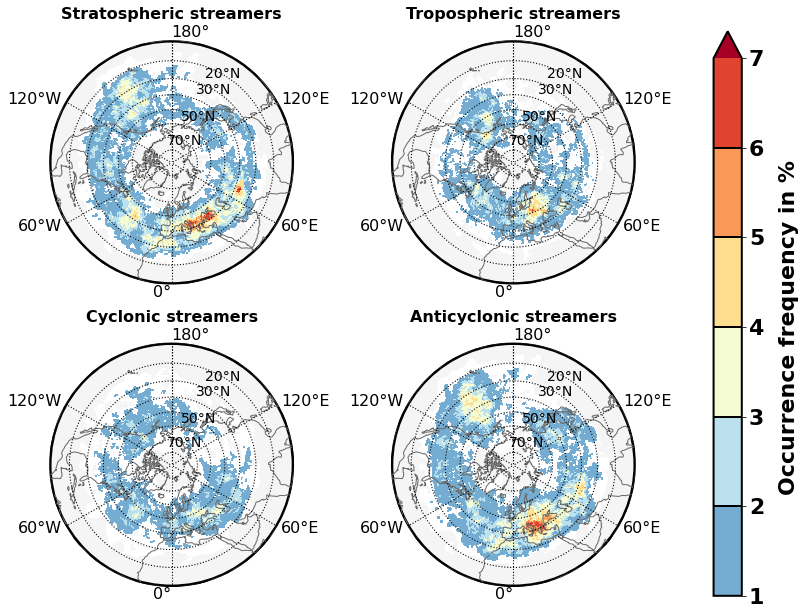

In [9]:
# new cmap
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap("RdYlBu_r")
new_cmap = truncate_colormap(cmap, 0.2, 1)
new_cmap.set_bad(color="whitesmoke")

data_crs = ccrs.PlateCarree()
proj = ccrs.NorthPolarStereo()

fig, axes = plt.subplots(2,2, subplot_kw=dict(projection=proj), figsize=(14,14))

plt.subplots_adjust(left  = 0.125,  # the left side of the subplots of the figure
                    right = 0.9,    # the right side of the subplots of the figure
                    bottom = 0.1,   # the bottom of the subplots of the figure
                    top = 0.9,      # the top of the subplots of the figure
                    wspace = 0.4,   # the amount of width reserved for blank space between subplots
                    hspace = -0.4   # the amount of height reserved for white space between subplots)
                   )

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

lev = [1,2,3,4,5,6,7]

d1 = xr.where(ds.flag_1==1,1,0).sum(dim="time")/len(ds.time)*100
p1 = d1.where(d1>0).plot(ax=axes[0,0], cmap = new_cmap, transform=data_crs, levels = lev, add_colorbar=False, extend = "max")

d2 = xr.where(ds.flag_1==2,1,0).sum(dim="time")/len(ds.time)*100
p2 = d2.where(d2>0).plot(ax=axes[0,1], cmap = new_cmap, transform=data_crs, levels = lev, add_colorbar=False, extend = "max")

d3 = xr.where(ds.flag_2==1,1,0).sum(dim="time")/len(ds.time)*100
p3 = d3.where(d3>0).plot(ax=axes[1,0], cmap = new_cmap, transform=data_crs, levels = lev, add_colorbar=False, extend = "max")

d4 = xr.where(ds.flag_2==2,1,0).sum(dim="time")/len(ds.time)*100
p4 = d4.where(d4>0).plot(ax=axes[1,1], cmap = new_cmap, transform=data_crs, levels = lev, add_colorbar=False, extend = "max")
  
cbar = plt.colorbar(p1, ax=axes.flat, shrink=0.7, drawedges=True, pad = 0.1)
cbar.ax.set_yticklabels(lev, fontsize=22, weight='bold')
cbar.set_label(label="Occurrence frequency in %",size=22, fontweight="bold",labelpad=15)

cbar.outline.set_color('black')
cbar.outline.set_linewidth(2)

cbar.dividers.set_color('black')
cbar.dividers.set_linewidth(2)

if index =="ot":
    titles = ["Cyclonic overturning by orientation", "Anticyclonic overturning by orientation", "Cyclonic overturning by momentum flux", "Anticyclonic overturning by momentum flux"]
if index =="streamer":
    titles = ["Stratospheric streamers", "Tropospheric streamers", "Cyclonic streamers", "Anticyclonic streamers"]
    
for ax,title in zip(axes.flat, titles):
    ax.set_extent([-180, 180, 10, 89], crs=data_crs)
    ax.add_feature(cfeature.COASTLINE, color="dimgrey")
    gr = ax.gridlines(draw_labels=True, color="black", linestyle="dotted", linewidth = 1.1)
    gr.xlabel_style = {'size': 16, 'color': 'black', "rotation":0}
    gr.ylabel_style = {'size': 14, 'color': 'black'}
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.add_patch(mpatches.Circle((0.5, 0.5), radius=0.5, color='k', linewidth=4, fill=False, transform = ax.transAxes))
    ax.set_title("")
    ax.set_title(title, fontweight='bold',fontsize=16)

plt.show()